## Setup

We begin by importing our dependencies.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time
from random import random

Set our seed and other configurations for reproducibility.

In [9]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
PATH = './cifar_net.pth'

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [10]:
from model import *
from data import *

In [11]:
batch_size = 1024 * 6
dataset = Loader(batch_size=batch_size)
trainloader = dataset.trainloader

def examples(trainloader):
    # get some random training images
    dataiter = iter(trainloader)
    images, _ = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images[:4]))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


print('Examples:')
# examples(trainloader)

Wait for both datasets to be downloaded and verified.
Files already downloaded and verified
Files already downloaded and verified
Examples:


## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [5]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
net = AE().to(device)
print('Network:', net)


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

Network: AE(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
)


We train our autoencoder for our specified number of epochs.

In [7]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""


print("start training")
# if PATH:
#     net.load_state_dict(torch.load(PATH))
#     net.to(device)

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, loss))
 
    print('Finished Training')
    elapsed_time = time.time() - start_time
    print(str( round(elapsed_time)) + 's')
    return train_loss

torch.save(net.state_dict(), PATH) 
loss = train(net, dataset.trainloader, 100)

start training
Epoch 1 of 100, Train Loss: 0.255
Epoch 2 of 100, Train Loss: 0.238
Epoch 3 of 100, Train Loss: 0.223
Epoch 4 of 100, Train Loss: 0.213
Epoch 5 of 100, Train Loss: 0.200
Epoch 6 of 100, Train Loss: 0.191
Epoch 7 of 100, Train Loss: 0.185
Epoch 8 of 100, Train Loss: 0.180
Epoch 9 of 100, Train Loss: 0.177
Epoch 10 of 100, Train Loss: 0.174
Epoch 11 of 100, Train Loss: 0.172
Epoch 12 of 100, Train Loss: 0.170
Epoch 13 of 100, Train Loss: 0.169
Epoch 14 of 100, Train Loss: 0.168
Epoch 15 of 100, Train Loss: 0.166
Epoch 16 of 100, Train Loss: 0.165
Epoch 17 of 100, Train Loss: 0.165
Epoch 18 of 100, Train Loss: 0.164
Epoch 19 of 100, Train Loss: 0.163
Epoch 20 of 100, Train Loss: 0.161
Epoch 21 of 100, Train Loss: 0.162
Epoch 22 of 100, Train Loss: 0.161
Epoch 23 of 100, Train Loss: 0.161
Epoch 24 of 100, Train Loss: 0.160
Epoch 25 of 100, Train Loss: 0.159
Epoch 26 of 100, Train Loss: 0.159
Epoch 27 of 100, Train Loss: 0.158
Epoch 28 of 100, Train Loss: 0.158
Epoch 29 of 10

NameError: name 'loss' is not defined

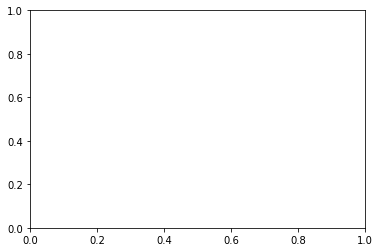

In [5]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

fig, ax = plt.subplots()
ax.plot(loss)
ax.set(xlabel='epoch', ylabel='loss')
ax.grid()
plt.draw()

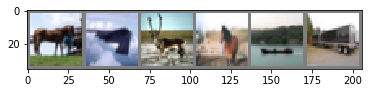

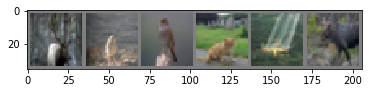

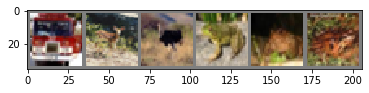

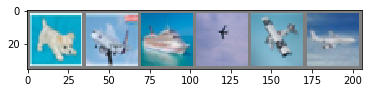

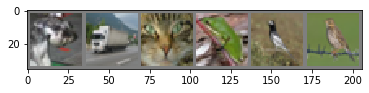

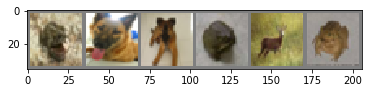

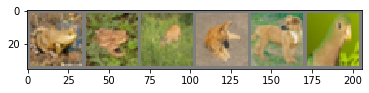

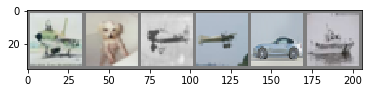

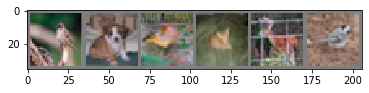

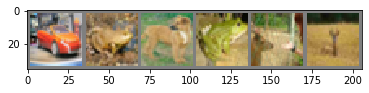

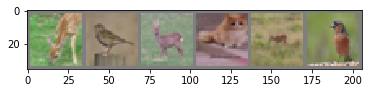

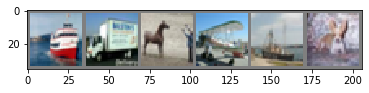

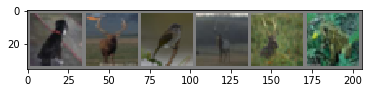

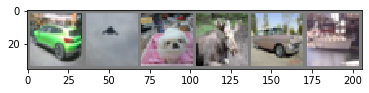

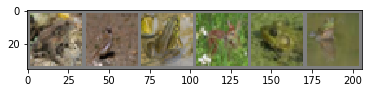

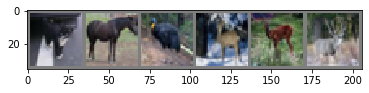

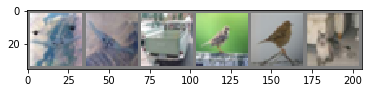

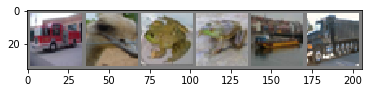

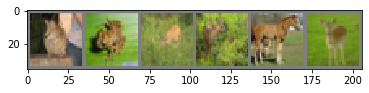

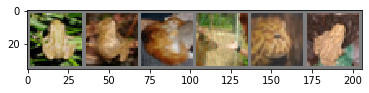

In [15]:
from eval import *

# load test set
dataset_iter = iter(dataset.testloader)
images, _ = dataset_iter.next()
length = len(images)

# prepare network
net = AE()
net.load_state_dict(torch.load(PATH))
net.getLatentSpace(True)

# process images
outputs = net(images).data.numpy()
outputShape = np.shape(outputs)
outputs = outputs.flatten().reshape(length, np.prod(outputShape[1:]))

# get 20 closest image sets
for _ in range(20):
    closest = findNClosest(outputs[round(random() * length)], outputs, 6)
    closeImages = []
    for img in closest:
        closeImages.append(images[int(img[-1])])
    imshow(torchvision.utils.make_grid(closeImages))